![MLA Logo](https://drive.corp.amazon.com/view/mrruckma@/MLA_headerv2.png?download=true)

#### In this example, we will use Transfer Learning. A pre-trained Alexnet is used to classify five image categories. You can see in the training loop that it only takes 5 epochs to reach the 98% validation accuracy. 

### 1. Download and Read the Dataset

#### We have the following classes:
### * Class 0: Inconclusive
### * Class 1: Two wheels
### * Class 2: Four wheels
### * Class 3: Not luggage
### * Class 4: Zero wheels

Let's download the dataset from our S3 bucket into Eider. 

In [6]:
#!pip install -U scikit-image
#!pip install -U numpy

#Let's read in our training data. ASINs correspond to those in Leaderboard's ID.
import pandas as pd
import boto3

df = pd.read_pickle("./training_data.pkl")
tf = pd.read_pickle("./test_data.pkl")

In [2]:
df.head()

,ID,data,label
0,1588,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
1,2011,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
2,1321,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4
3,669,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3
4,1674,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1


#### Let's look at some examples. The first column of the numpy array holds images and second column keeps the class information. 

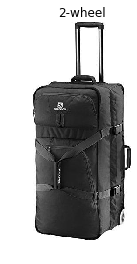

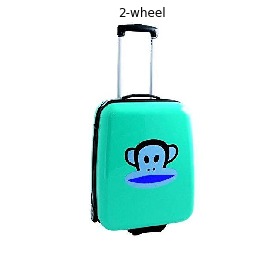

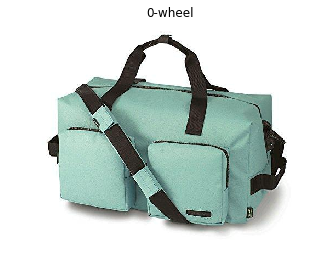

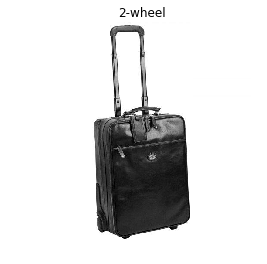

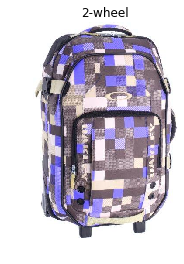

In [4]:
import matplotlib.pyplot as plt

classes = ['inconclusive', '2-wheel', '4-wheel', 'not-luggage', '0-wheel']

plt.imshow(df["data"][551])
plt.title(classes[df["label"][551]])
plt.axis("off")
plt.show()

plt.imshow(df["data"][1119])
plt.title(classes[df["label"][1119]])
plt.axis("off")
plt.show()

plt.imshow(df["data"][156])
plt.title(classes[df["label"][156]])
plt.axis("off")
plt.show()

plt.imshow(df["data"][1526])
plt.title(classes[df["label"][1526]])
plt.axis("off")
plt.show()

plt.imshow(df["data"][15])
plt.title(classes[df["label"][15]])
plt.axis("off")
plt.show()

### 2. Split the dataset and Process Images
#### * We split the original dataset into Training (80%), Validation (10%) and Test (10%) subsets. 
#### * We will process images by resizing to 224x224 and converting (row, column, channel) to (channel, row, column)

In [7]:
import numpy as np
from skimage.transform import resize

# Let's split to data into training (80%), validation (10%) and test (10%) subsets.
tr_pct=0.9
train_indices = np.arange(0, int(tr_pct*len(df)))
val_indices = np.arange(int(tr_pct*len(df)), int(len(df)))
test_indices = np.arange(0, len(tf))

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]
test_df = tf.iloc[test_indices]

del df
del tf

def getImages(images):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224))
    
    # Iterate through the image data
    for i, im in enumerate(images):
        # Get image from the data column of the current row
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # Assign the value in the image array
        image_arr[i] = im

    return image_arr
    
train_images, train_labels = getImages(train_df["data"].values), train_df["label"].values
validation_images, validation_labels = getImages(val_df["data"].values), val_df["label"].values

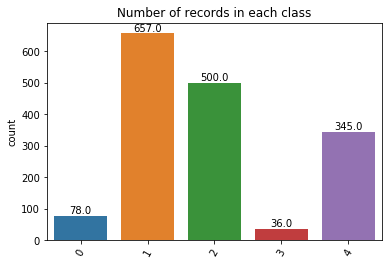

In [8]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=train_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

### 3. Build the Convolutional Neural Network
* We will use two Convolution-Pooling pairs
* Flatten after them
* A fully connected layer
* Dense output layer

In [9]:
from mxnet.gluon.model_zoo import vision
import mxnet as mx

def build_network(num_outputs):
    # Set this to GPU or CPU
    ctx = mx.gpu()
    #ctx = mx.cpu()

    # Get the pre-trained network
    pre_trained_net = vision.alexnet(pretrained=True, ctx=ctx)

    # Get the non-trained network
    net = vision.alexnet(classes=num_outputs, ctx=ctx)
    
    # Initialize weights
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    
    # Copy weights from the trained network
    net.features = pre_trained_net.features

    return net

### 4. Construct the confusion matrix plot function
#### We will use this function to plot our confusion matrix at the end of each epoch. (Epoch: One full pass through our dataset)

Let's write a function to plot a confusion matrix to see class-specific performance after each epoch

In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (5, 5))
    plt.title('Validation Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    plt.show()

### 5. Training the network
#### Let's put the training data in the MXnet format and start training. Summarizing our steps:
#### * Select the correct compute type cpu or gpu
#### * Split the dataset into training, validation and test splits
#### * Create Gluon-specific data loaders
#### * Create the network and training algorithm
#### * Loop through dataset. We have only 5 epochs thaks to pre-trained network. We will train with training dataset and validate with the validation dataset. 

Epoch 0, training loss: 1.90, validation loss: 1.02, training accuracy: 0.39, validation accuracy: 0.56


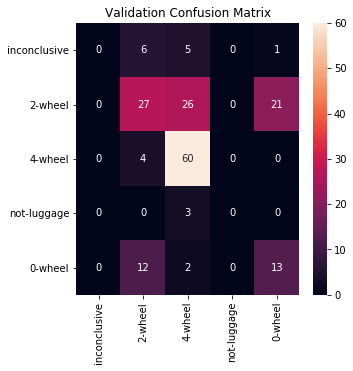

Epoch 1, training loss: 1.08, validation loss: 0.86, training accuracy: 0.57, validation accuracy: 0.65


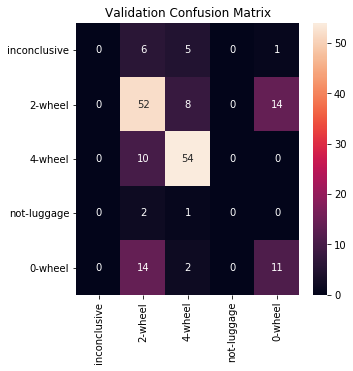

Epoch 2, training loss: 0.89, validation loss: 0.76, training accuracy: 0.67, validation accuracy: 0.70


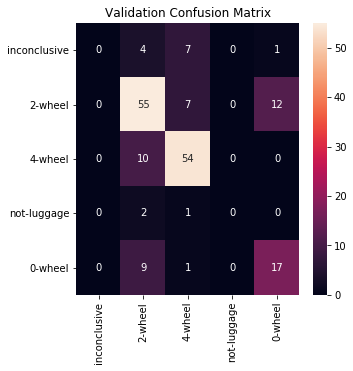

Epoch 3, training loss: 0.79, validation loss: 0.70, training accuracy: 0.70, validation accuracy: 0.73


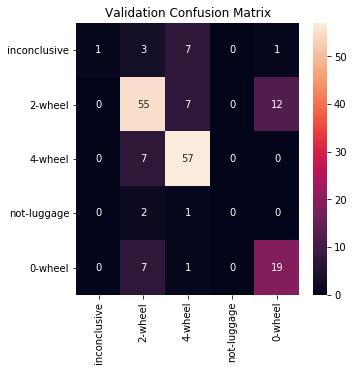

Epoch 4, training loss: 0.74, validation loss: 0.67, training accuracy: 0.72, validation accuracy: 0.73


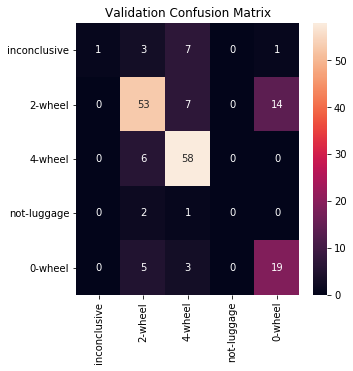

Epoch 5, training loss: 0.69, validation loss: 0.64, training accuracy: 0.72, validation accuracy: 0.76


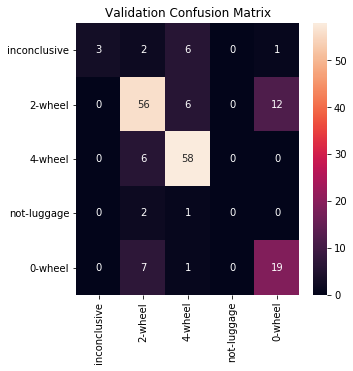

Epoch 6, training loss: 0.66, validation loss: 0.63, training accuracy: 0.75, validation accuracy: 0.77


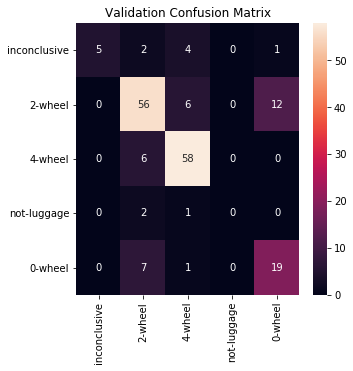

Epoch 7, training loss: 0.63, validation loss: 0.62, training accuracy: 0.76, validation accuracy: 0.77


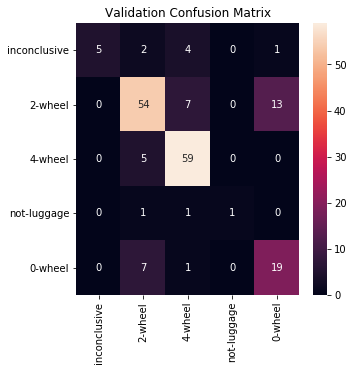

Epoch 8, training loss: 0.59, validation loss: 0.61, training accuracy: 0.77, validation accuracy: 0.77


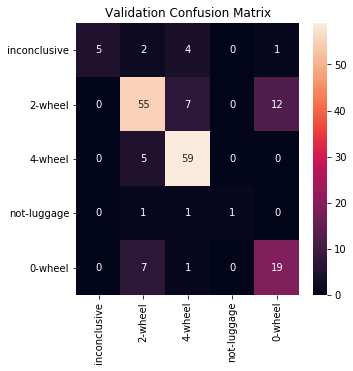

Epoch 9, training loss: 0.59, validation loss: 0.59, training accuracy: 0.77, validation accuracy: 0.77


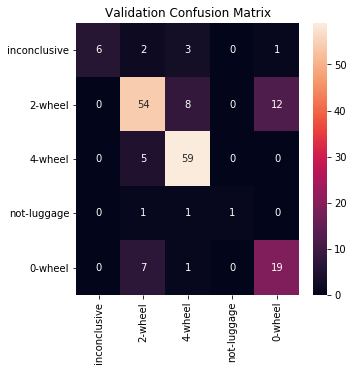

Epoch 10, training loss: 0.55, validation loss: 0.59, training accuracy: 0.79, validation accuracy: 0.77


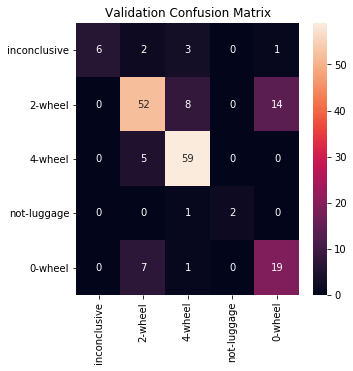

Epoch 11, training loss: 0.53, validation loss: 0.59, training accuracy: 0.81, validation accuracy: 0.76


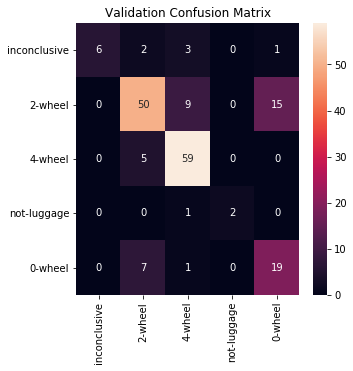

Epoch 12, training loss: 0.51, validation loss: 0.59, training accuracy: 0.81, validation accuracy: 0.76


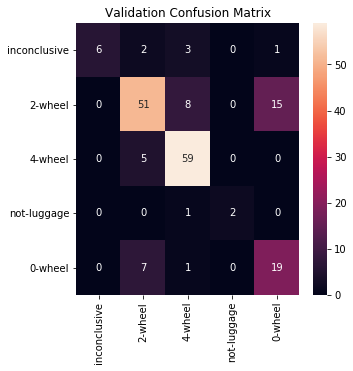

Epoch 13, training loss: 0.50, validation loss: 0.58, training accuracy: 0.81, validation accuracy: 0.76


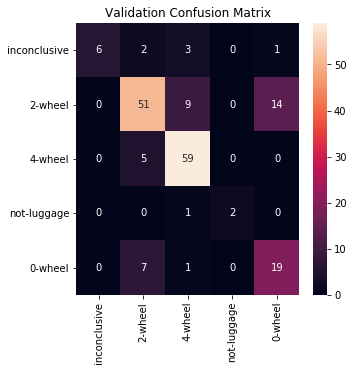

Epoch 14, training loss: 0.48, validation loss: 0.58, training accuracy: 0.82, validation accuracy: 0.76


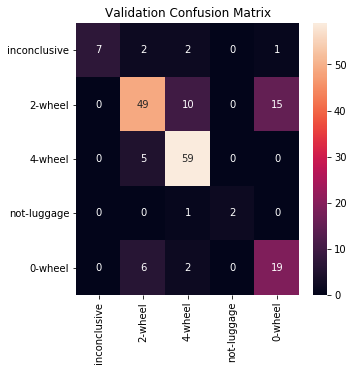

Epoch 15, training loss: 0.47, validation loss: 0.57, training accuracy: 0.81, validation accuracy: 0.78


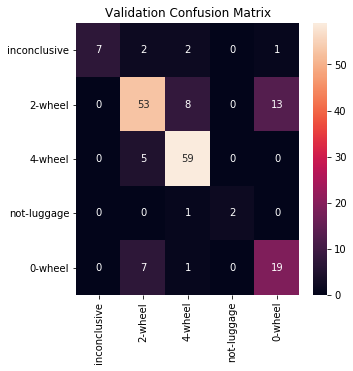

Epoch 16, training loss: 0.46, validation loss: 0.57, training accuracy: 0.82, validation accuracy: 0.77


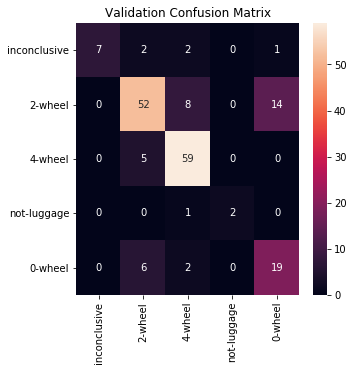

Epoch 17, training loss: 0.42, validation loss: 0.57, training accuracy: 0.84, validation accuracy: 0.77


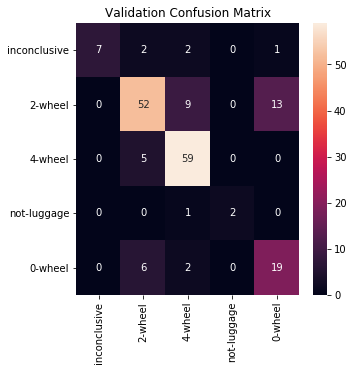

Epoch 18, training loss: 0.43, validation loss: 0.58, training accuracy: 0.85, validation accuracy: 0.77


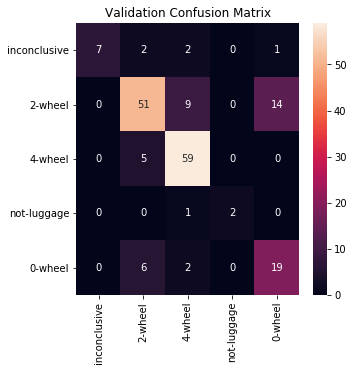

Epoch 19, training loss: 0.42, validation loss: 0.57, training accuracy: 0.84, validation accuracy: 0.76


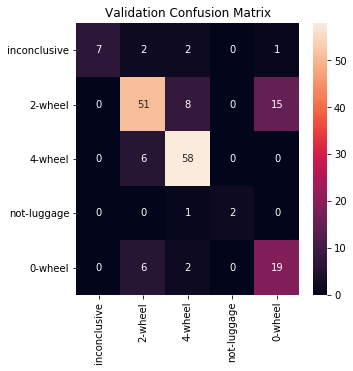

Epoch 20, training loss: 0.40, validation loss: 0.58, training accuracy: 0.85, validation accuracy: 0.77


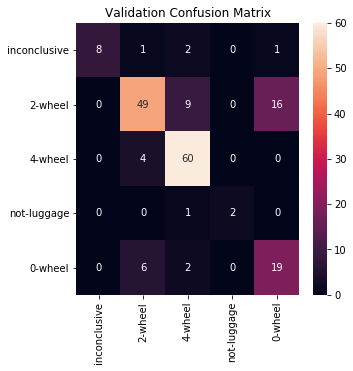

Epoch 21, training loss: 0.39, validation loss: 0.57, training accuracy: 0.85, validation accuracy: 0.76


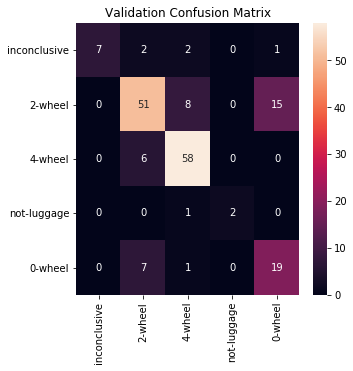

Epoch 22, training loss: 0.37, validation loss: 0.56, training accuracy: 0.87, validation accuracy: 0.77


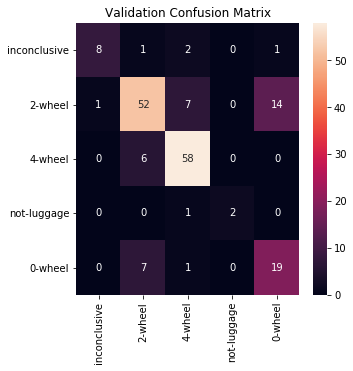

Epoch 23, training loss: 0.37, validation loss: 0.57, training accuracy: 0.86, validation accuracy: 0.78


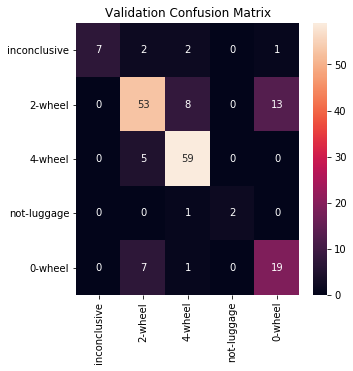

Epoch 24, training loss: 0.34, validation loss: 0.58, training accuracy: 0.87, validation accuracy: 0.76


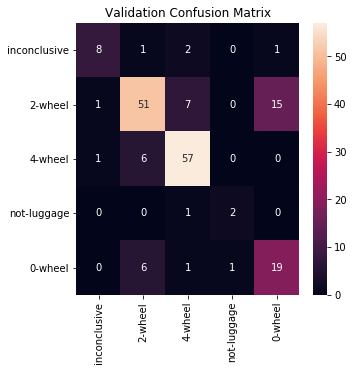

Epoch 25, training loss: 0.35, validation loss: 0.57, training accuracy: 0.87, validation accuracy: 0.77


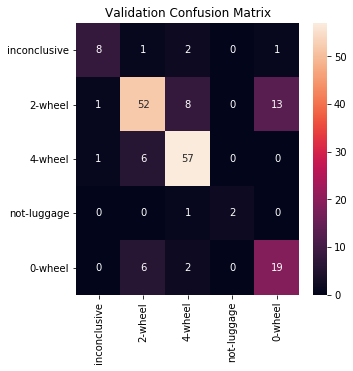

Epoch 26, training loss: 0.33, validation loss: 0.58, training accuracy: 0.89, validation accuracy: 0.76


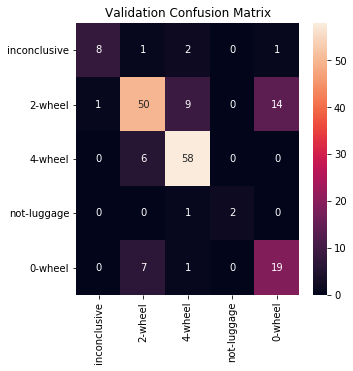

Epoch 27, training loss: 0.34, validation loss: 0.57, training accuracy: 0.88, validation accuracy: 0.77


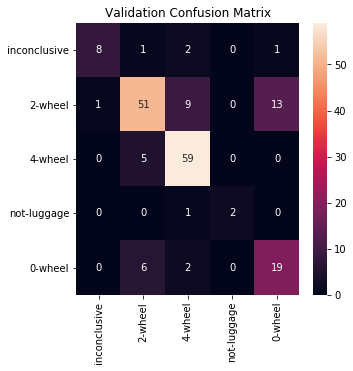

Epoch 28, training loss: 0.30, validation loss: 0.57, training accuracy: 0.89, validation accuracy: 0.77


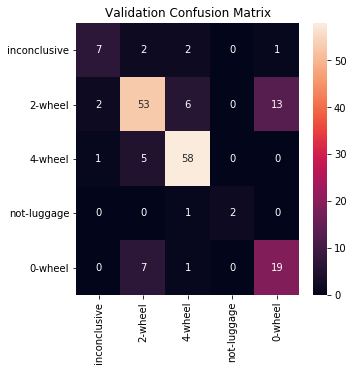

Epoch 29, training loss: 0.32, validation loss: 0.58, training accuracy: 0.88, validation accuracy: 0.77


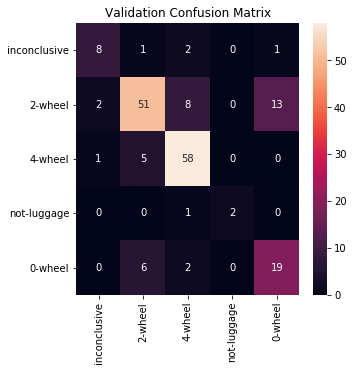

Epoch 30, training loss: 0.28, validation loss: 0.57, training accuracy: 0.90, validation accuracy: 0.78


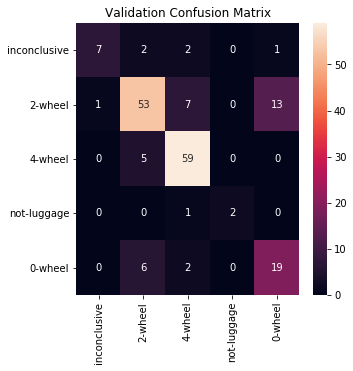

Epoch 31, training loss: 0.29, validation loss: 0.58, training accuracy: 0.89, validation accuracy: 0.77


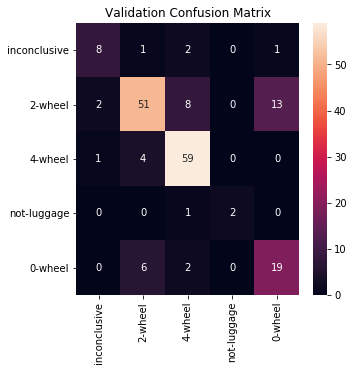

Epoch 32, training loss: 0.27, validation loss: 0.57, training accuracy: 0.90, validation accuracy: 0.78


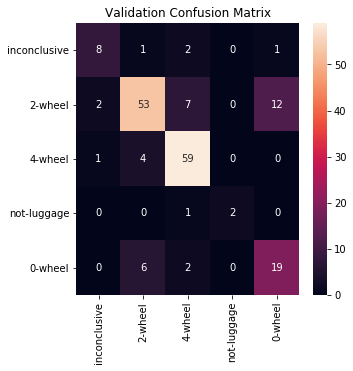

Epoch 33, training loss: 0.27, validation loss: 0.58, training accuracy: 0.90, validation accuracy: 0.78


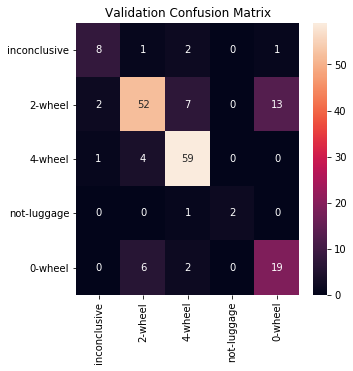

Epoch 34, training loss: 0.25, validation loss: 0.57, training accuracy: 0.91, validation accuracy: 0.78


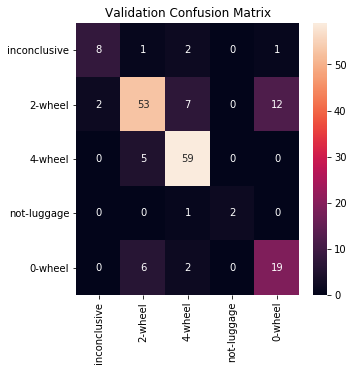

Epoch 35, training loss: 0.24, validation loss: 0.59, training accuracy: 0.91, validation accuracy: 0.78


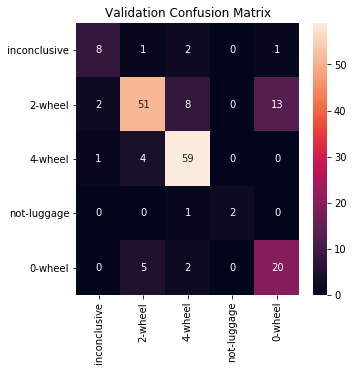

Epoch 36, training loss: 0.25, validation loss: 0.58, training accuracy: 0.92, validation accuracy: 0.78


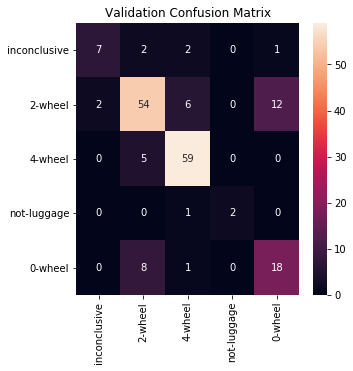

Epoch 37, training loss: 0.24, validation loss: 0.59, training accuracy: 0.91, validation accuracy: 0.78


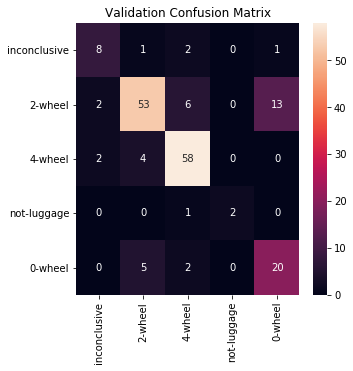

Epoch 38, training loss: 0.24, validation loss: 0.59, training accuracy: 0.92, validation accuracy: 0.78


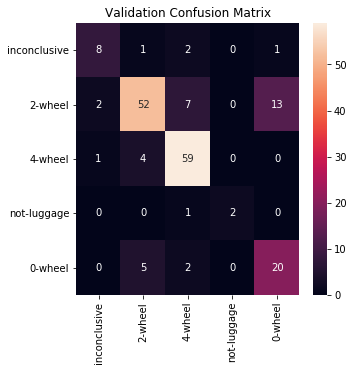

Epoch 39, training loss: 0.22, validation loss: 0.60, training accuracy: 0.92, validation accuracy: 0.79


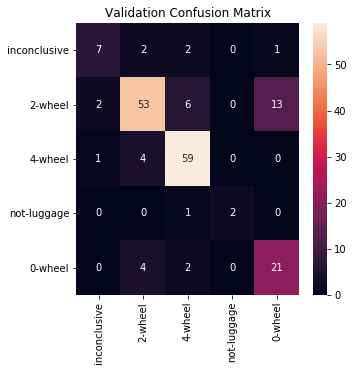

Epoch 40, training loss: 0.21, validation loss: 0.60, training accuracy: 0.92, validation accuracy: 0.78


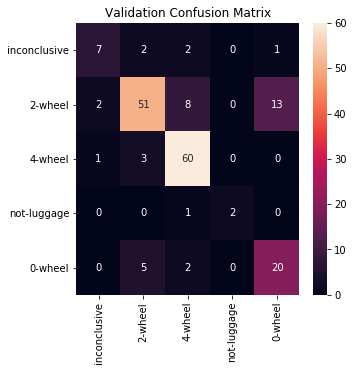

Epoch 41, training loss: 0.21, validation loss: 0.62, training accuracy: 0.93, validation accuracy: 0.78


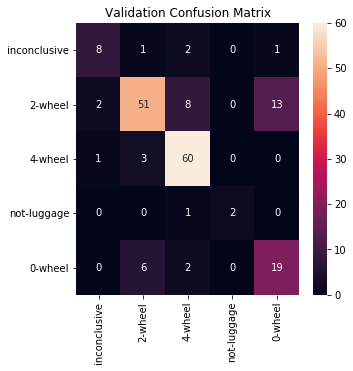

Epoch 42, training loss: 0.21, validation loss: 0.60, training accuracy: 0.93, validation accuracy: 0.79


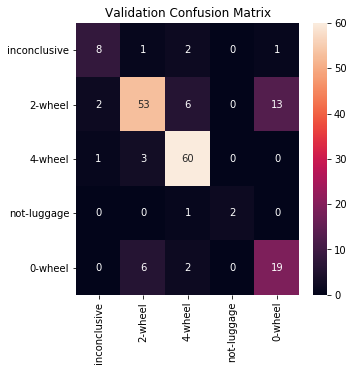

Epoch 43, training loss: 0.19, validation loss: 0.59, training accuracy: 0.93, validation accuracy: 0.78


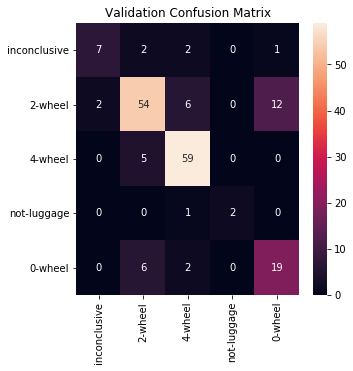

Epoch 44, training loss: 0.19, validation loss: 0.61, training accuracy: 0.94, validation accuracy: 0.79


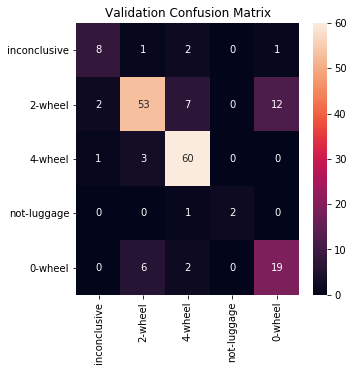

Epoch 45, training loss: 0.19, validation loss: 0.61, training accuracy: 0.93, validation accuracy: 0.80


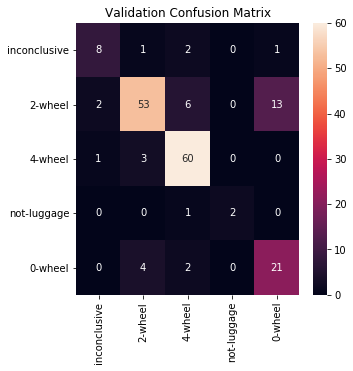

Epoch 46, training loss: 0.16, validation loss: 0.60, training accuracy: 0.95, validation accuracy: 0.78


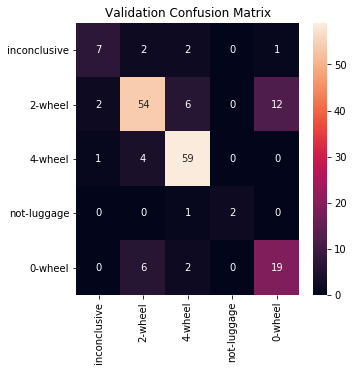

Epoch 47, training loss: 0.17, validation loss: 0.62, training accuracy: 0.94, validation accuracy: 0.80


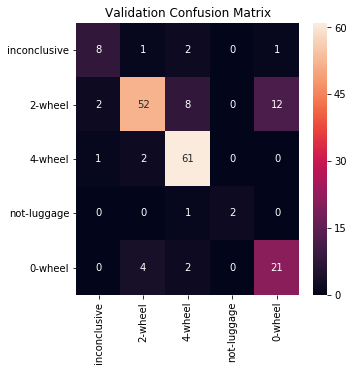

Epoch 48, training loss: 0.18, validation loss: 0.60, training accuracy: 0.94, validation accuracy: 0.80


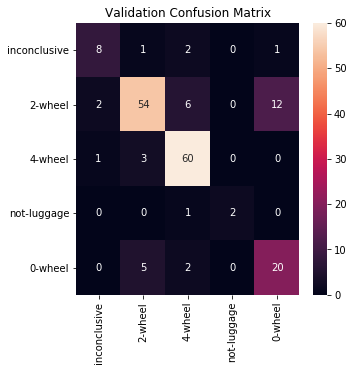

Epoch 49, training loss: 0.16, validation loss: 0.62, training accuracy: 0.94, validation accuracy: 0.80


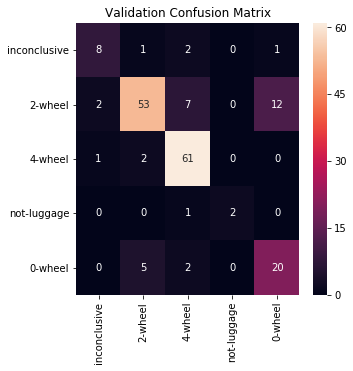

In [36]:
import numpy as np
from mxnet import gluon, autograd, ndarray
import mxnet as mx
import mxnet.ndarray as nd
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from sklearn.metrics import accuracy_score

# Set this to GPU or CPU 
ctx = mx.gpu()
#ctx = mx.cpu()

# Set params
batch_size = 250
epochs = 50
learning_rate = 0.001
momentum = 0.9
wd = 0.0001
optimizer = 'nag'

# ------ Create Network and Training Logic -------- #

# Create the network. We have 5 classes
num_outputs = 5

net = build_network(num_outputs)

# Define loss and trainer.
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    'learning_rate': learning_rate,
    'momentum': momentum,
    'wd': wd
})
# ------------------------------------------------- #

for epoch in range(epochs):
    
    # training loop (with autograd and trainer steps, etc.)
    cumulative_train_loss = 0
    train_predictions = []
    for i in range(0, train_images.shape[0], batch_size):
        data = nd.array(train_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
        label = nd.array(train_labels[i:i + batch_size]).as_in_context(ctx)

        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
        
    train_loss = cumulative_train_loss/len(train_images)

    # validation loop
    cumulative_valid_loss = 0
    val_predictions = []
    for i in range(0, validation_images.shape[0], batch_size):
        data = nd.array(validation_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
        label = nd.array(validation_labels[i:i + batch_size]).as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
        
    valid_loss = cumulative_valid_loss/len(validation_images)
    
    # Calculate training and validation accuracies
    train_accuracy = accuracy_score(train_labels, train_predictions)
    validation_accuracy = accuracy_score(validation_labels, val_predictions)
    
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    plot_confusion_matrix(validation_labels, val_predictions)

### 6. Testing the network
#### Now, it is time to test our network on the test set. 
#### __Important Note:__ For your final project, you will get the test set from an S3 bucket, here we are using the test subset we already created. You don't need to create this test subset for your final project (just read it from the s3 bucket).
#### We will do something similar to the validation loop above

In [37]:
test_images = getImages(test_df["data"].values)
test_predictions = []
for i in range(0, test_images.shape[0], batch_size):
    data = nd.array(test_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

[1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 4, 2, 1, 1, 4, 4, 1, 1, 1, 1, 4, 1, 1, 0, 2, 1, 1, 1, 0, 1, 3, 4, 2, 1, 2, 2, 2, 3, 2, 1, 4, 2, 4, 1, 2, 2, 1, 2, 4, 1, 4, 1, 2, 1, 1, 4, 2, 2, 1, 1, 4, 4, 1, 2, 0, 1, 1, 1, 2, 4, 2, 4, 1, 4, 4, 1, 1, 1, 2, 4, 2, 1, 4, 4, 4, 1, 1, 2, 4, 1, 1, 1, 2, 2, 2, 1, 1, 2, 4, 1, 1, 4, 2, 1, 2, 2, 4, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 4, 1, 4, 1, 2, 4, 2, 0, 1, 1, 2, 4, 2, 1, 4, 2, 2, 1, 1, 2, 2, 2, 1, 3, 4, 2, 4, 4, 1, 4, 3, 4, 1, 1, 1, 2, 2, 4, 4, 1, 1, 2, 2, 2, 2, 2, 4, 4, 3, 2, 0, 1, 2, 1, 2, 2, 1, 2, 4, 1, 2, 4, 4, 2, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 4, 4, 2, 2, 2, 2, 2, 0, 2, 2, 4, 4, 1, 0, 2, 2, 1, 1, 2, 4, 1, 1, 2, 2, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 4, 2, 2, 1, 4, 2, 1, 1, 4, 1, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 4, 2, 2, 4, 1, 0, 1, 4, 1, 1, 2, 2, 1, 4, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 1, 2, 2, 1, 2, 2, 1, 4, 1, 1, 4, 4, 0, 1, 4, 2, 1, 2, 2, 1, 1, 1, 1, 4, 1, 1, 1, 3, 0, 2, 0, 2, 2, 2, 1, 4, 

#### Let's print the first 10 predictions (0: Ring, 1: Shirt, 2: Watch, 3: Jeans, 4: Shoe) and the first 10 images. 
#### If you remember, we changed image data order from (row, col, channel) to (channel, row, col), we will revert those changes to plot our images

In [39]:
import pandas as pd

result_df = pd.DataFrame(columns=['ID', 'label'])
result_df["ID"] = test_df["ID"]
result_df["label"] = test_predictions

result_df.to_csv("./results-transfer-5.csv", index=False)

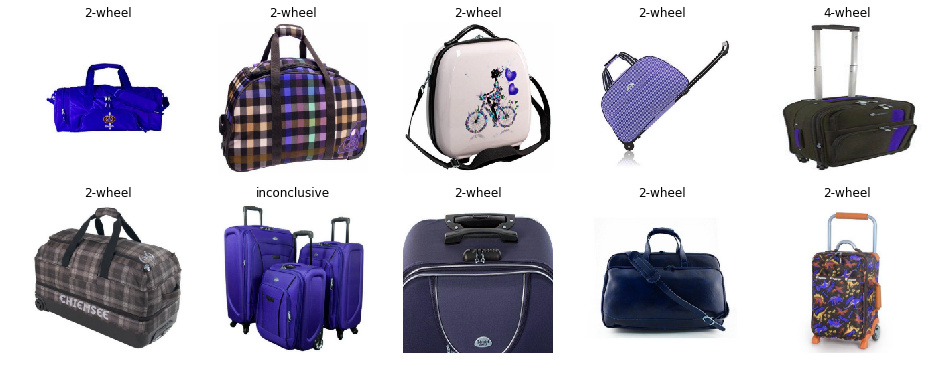

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))

for i in range(0, 10):
    plt.subplot(5, 5, i+1)
    im = test_images[i]
    label = test_predictions[i]
    im = np.moveaxis(im, 0, 2)
    plt.title(classes[label])
    plt.imshow(im)
    plt.axis("off")